## Programmer: Chris Tralie

## Purpose

To estimate the phase of a 3D structure that's cycling but also drifing at the same time.  The steps I found worked reasonably well are:

1. Compute the velocity of the time series
2. Do a sliding window of the velocity to clean things up a bit
3. Build an unweighted graph laplacian on mutual nearest neighbors
4. Look at the eigenvectors of the graph laplacian and pick out the in phase and out of phase pare which are cycling the most with the period of interest
5. Compute the inverse tangent to estimate a phase angle

In [1]:
import numpy as np
import numpy.linalg as linalg
from scipy import sparse
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
def get_curv_vectors(X, MaxOrder, sigma, loop = False, m = 'nearest'):
    """
    Get smoothed curvature vectors up to a particular order
    Parameters
    ----------
    X: ndarray(N, d)
        An N x d matrix of points in R^d
    MaxOrder: int
        The maximum order of torsion to compute (e.g. 3 for position, velocity, and curvature, and torsion)
    sigma: float
        The smoothing amount
    loop: boolean
        Whether to treat this trajectory as a topological loop (i.e. add an edge between first and last point)
    
    Returns
    -------
    Curvs: A list of (N, 3) arrays, starting with the smoothed curve, then followed
           by the smoothed velocity, curvature, torsion, etc. up to the MaxOrder
    """
    from scipy.ndimage import gaussian_filter1d as gf1d
    if loop:
        m = 'wrap'
    XSmooth = gf1d(X, sigma, axis=0, order = 0, mode = m)
    Vel = gf1d(X, sigma, axis=0, order = 1, mode = m)
    VelNorm = np.sqrt(np.sum(Vel**2, 1))
    VelNorm[VelNorm == 0] = 1
    Curvs = [XSmooth, Vel]
    for order in range(2, MaxOrder+1):
        Tors = gf1d(X, sigma, axis=0, order=order, mode = m)
        for j in range(1, order):
            #Project away other components
            NormsDenom = np.sum(Curvs[j]**2, 1)
            NormsDenom[NormsDenom == 0] = 1
            Norms = np.sum(Tors*Curvs[j], 1)/NormsDenom
            Tors = Tors - Curvs[j]*Norms[:, None]
        Tors = Tors/(VelNorm[:, None]**order)
        Curvs.append(Tors)
    return Curvs

In [3]:
def getUnweightedLaplacianEigsDense(W):
    """
    Get eigenvectors of the unweighted Laplacian
    Parameters
    ----------
    W: ndarray(N, N)
        A symmetric similarity matrix that has nonnegative entries everywhere
    
    Returns
    -------
    v: ndarray(N, N)
        A matrix of eigenvectors
    """
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

In [4]:
def get_csm(X, Y):
    """
    Return the Euclidean cross-similarity matrix between the M points
    in the Mxd matrix X and the N points in the Nxd matrix Y.
    Parameters
    ----------
    X: ndarray(M, d)
        A point cloud with M points in d dimensions
    Y: ndarray(N, d)
        A point cloud with N points in d dimensions
    Returns
    -------
    D: ndarray(M, N)
        An MxN Euclidean cross-similarity matrix
    """
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    """
    Turn a cross-similarity matrix into a binary cross-simlarity matrix, using partitions instead of
    nearest neighbors for speed
    Parameters
    ----------
    D: ndarray(M, N)
        M x N cross-similarity matrix
    kappa: float
        If kappa = 0, take all neighbors
        If kappa < 1 it is the fraction of neighbors to consider
        Otherwise kappa is the number of neighbors to consider
    Returns
    -------
    B: ndarray(M, N)
        MxN binary cross-similarity matrix
    """
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    """
    Turn a cross-similarity matrix into a binary cross-simlarity matrix, where 
    an entry (i, j) is a 1 if and only if it is within the both the nearest
    neighbor set of i and the nearest neighbor set of j
    Parameters
    ----------
    D: ndarray(M, N)
        M x N cross-similarity matrix
    kappa: float
        If kappa = 0, take all neighbors
        If kappa < 1 it is the fraction of mutual neighbors to consider
        Otherwise kappa is the number of mutual neighbors to consider
    Returns
    -------
    B: ndarray(M, N)
        MxN binary cross-similarity matrix
    """
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

In [5]:
def sliding_window(dist, win):
    """
    Average down diagonals to simulate the effect of a sliding window
    """
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

Text(0.5, 1.0, 'Eigenvectors of Unweighted Graph Laplacian')

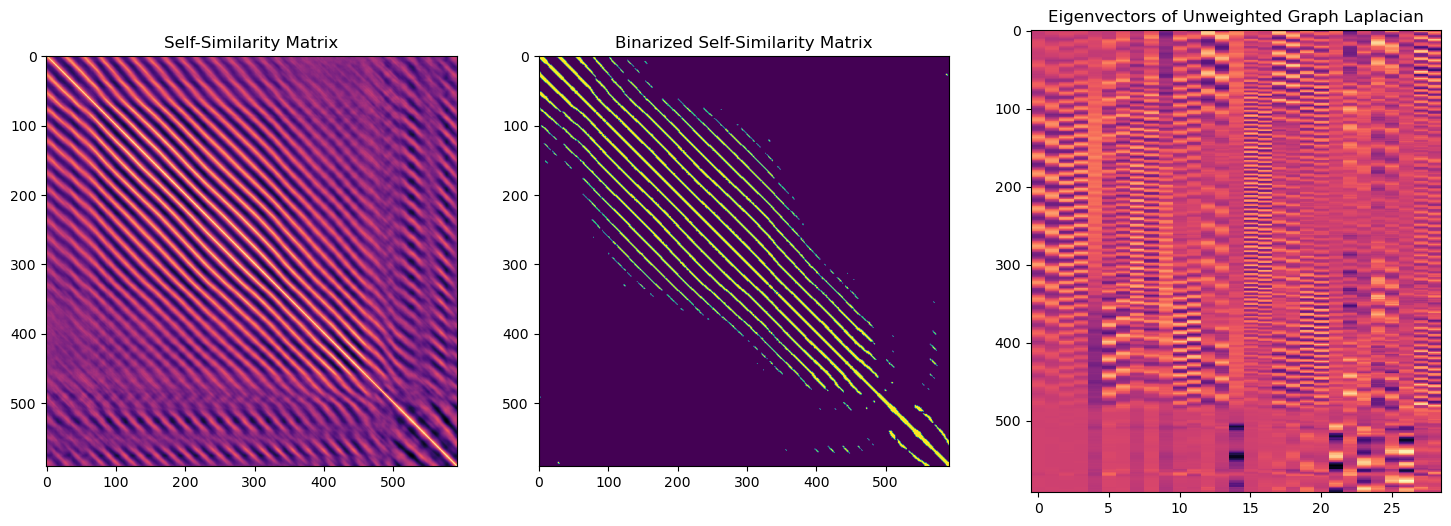

In [6]:
fin = open("alpha_carbons.csv")
X = [[float(f) for f in line.split(",")] for line in fin.readlines()]
X = np.array(X)
# Replace X with its velocity
X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]

D = get_csm(X, X)
# Clean up the matrix a bit by doing a sliding window of length roughly the period
period = 25
D = sliding_window(D, period)
# Clean up the matrix even more by binarizing it with nearest neighbors
B = csm_to_binary_mutual(D, 50)
#B = B[0:400, 0:400]
v = getUnweightedLaplacianEigsDense(1-B)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(D, cmap='magma_r')
plt.title("Self-Similarity Matrix")
plt.subplot(132)
plt.imshow(B)
plt.title("Binarized Self-Similarity Matrix")
plt.subplot(133)
plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
plt.title("Eigenvectors of Unweighted Graph Laplacian")

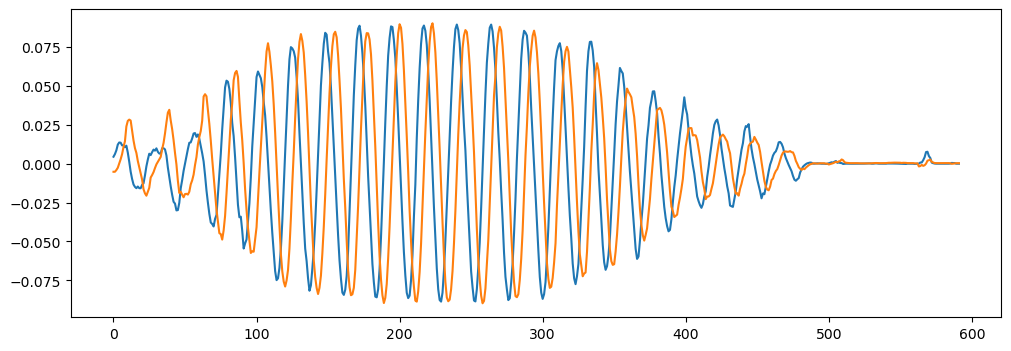

In [7]:
# The first two eigenvectors appear to hold the relevant information
plt.figure(figsize=(12, 4))
s = v[:, 0]
c = v[:, 1]
plt.plot(s)
plt.plot(c)

Text(0.5, 0, 'Sample Number')

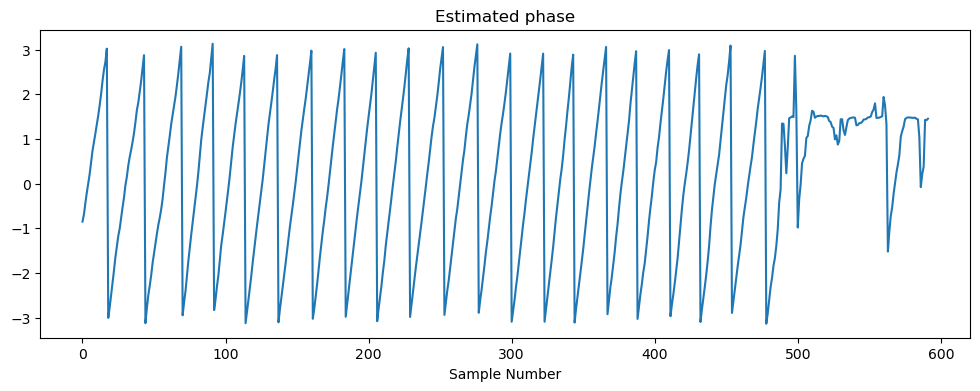

In [8]:
theta = np.arctan2(c, s)
plt.figure(figsize=(12, 4))
plt.plot(theta)
plt.title("Estimated phase")
plt.xlabel("Sample Number")